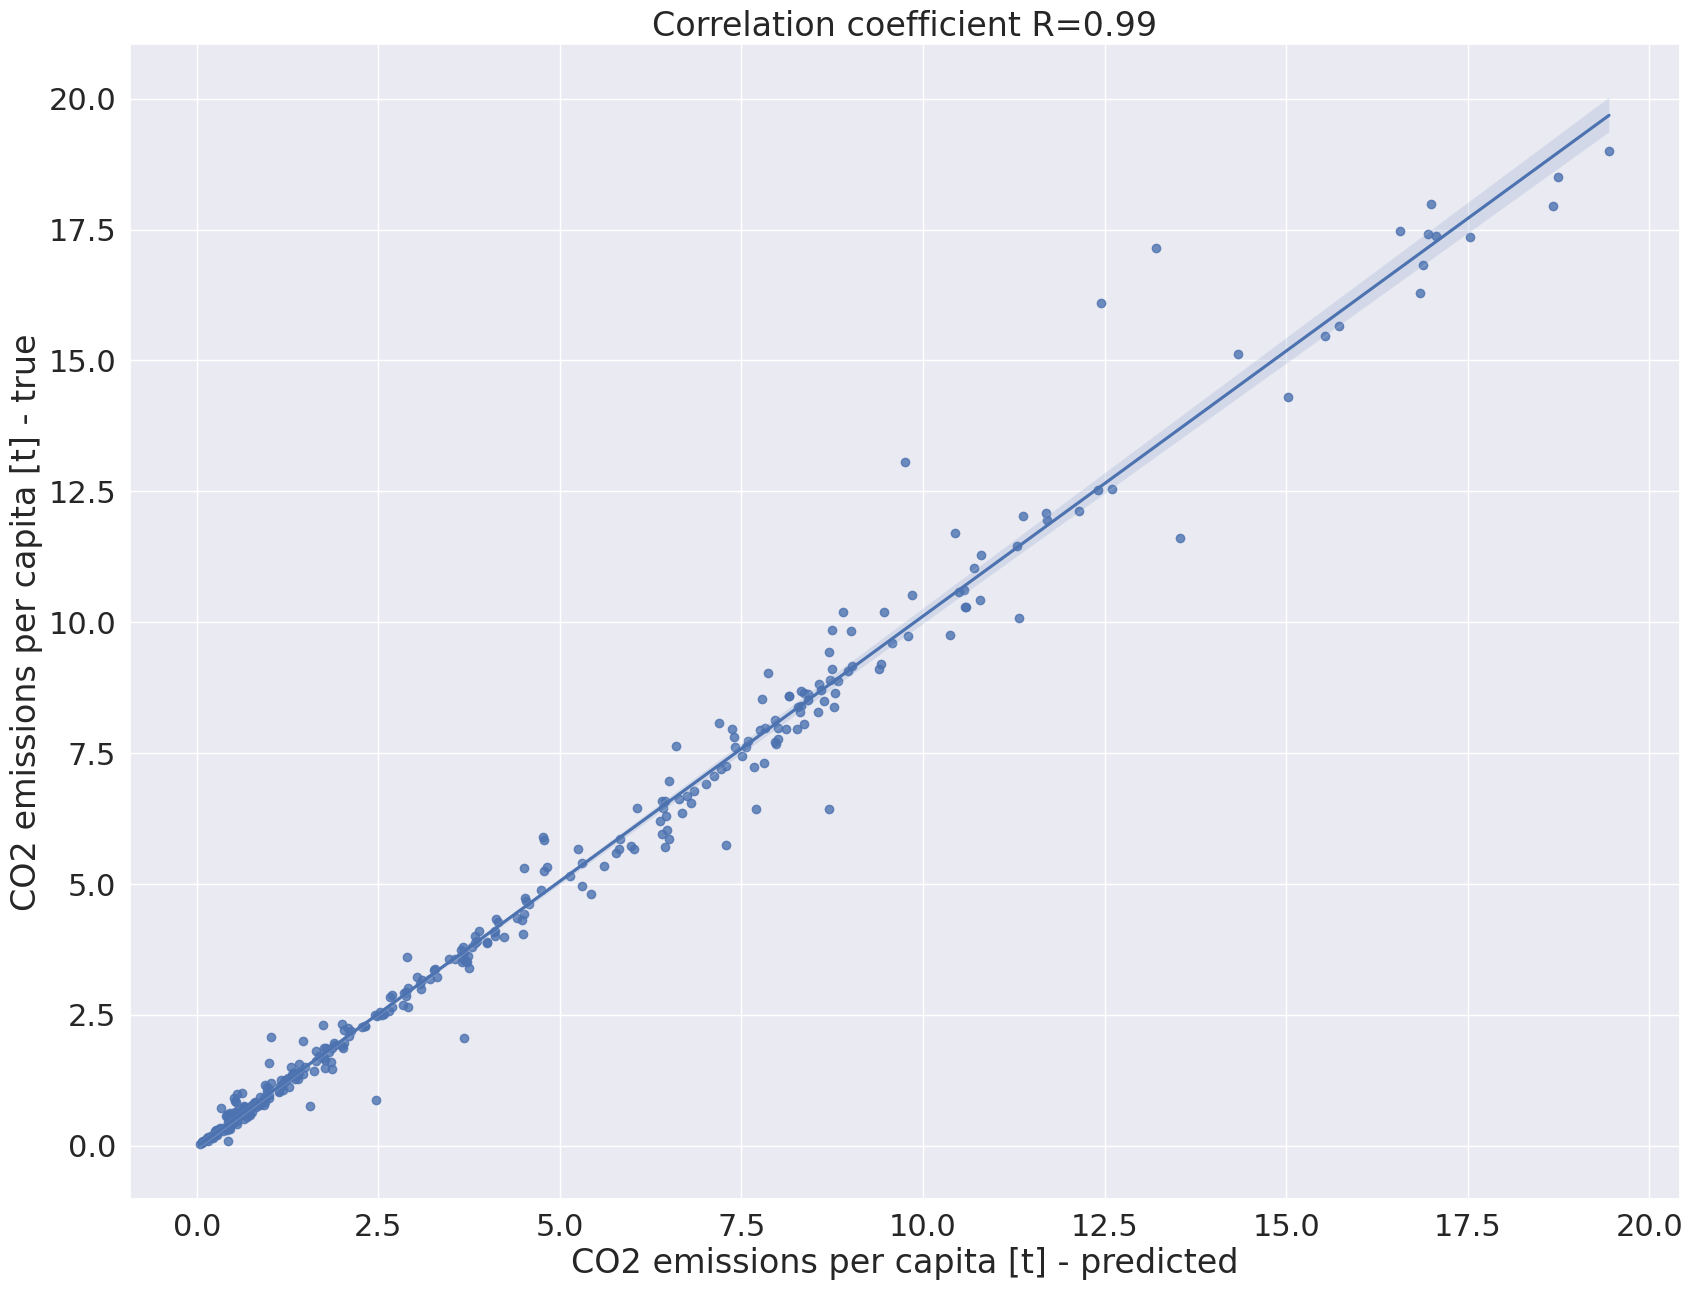

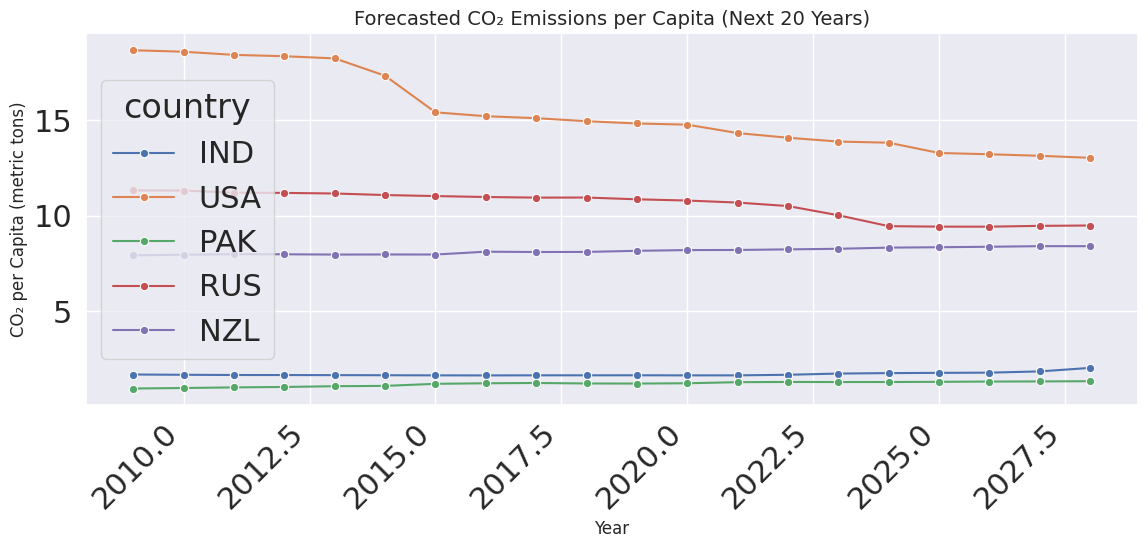

   country  year  co2_percap
15     IND  2024    1.769078
16     IND  2025    1.782205
17     IND  2026    1.793166
18     IND  2027    1.858996
19     IND  2028    2.042430


In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import feature_selection as fs
import numpy.random as nr
import joblib

# Set random state for reproducibility
random_state_num = 0
nr.seed(1)

# Load the dataset
data = pd.read_csv(r'data_cleaned.csv')

# Remove outliers (ARE)
data = data[data['country'] != 'ARE']

# Select features and label
feature_cols = ['cereal_yield', 'fdi_perc_gdp', 'gni_per_cap', 'en_per_cap',
                'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']
label_col = ['co2_per_cap']
features = np.array(data[feature_cols])
labels = np.array(data[label_col])

# Train-test split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=random_state_num)

# Feature selection with RFECV
feature_folds = KFold(n_splits=4, shuffle=True, random_state=random_state_num)
rf_selector = RandomForestRegressor(random_state=random_state_num)
selector = fs.RFECV(estimator=rf_selector, cv=feature_folds, scoring='r2', n_jobs=-1)
selector.fit(features_train, np.ravel(labels_train))

# Reduce features
features_train_reduced = selector.transform(features_train)
features_test_reduced = selector.transform(features_test)

# Hyperparameter tuning
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] + [None]
param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
inside_folds = KFold(n_splits=5, shuffle=True, random_state=random_state_num)
rf_tuner = RandomForestRegressor(random_state=random_state_num)
rf_model = RandomizedSearchCV(estimator=rf_tuner, param_distributions=param_grid,
                              random_state=random_state_num, refit=True,
                              cv=inside_folds, scoring='r2', return_train_score=True, n_jobs=-1)
rf_model.fit(features_train_reduced, np.ravel(labels_train))

# Save best model
rf_best_model = rf_model.best_estimator_

# Cross-validation evaluation
outside_folds = KFold(n_splits=10, shuffle=True, random_state=random_state_num)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, labels_train, cv=outside_folds, n_jobs=-1)

# Test set evaluation
predictions = rf_best_model.predict(features_test_reduced)
r2 = r2_score(y_true=labels_test, y_pred=predictions)
mse = mean_squared_error(y_true=labels_test, y_pred=predictions)
rmse = np.sqrt(mse)

# Regression plot
f, ax = plt.subplots(figsize=(20, 15))
sns.set_theme(font_scale=2)
sns.regplot(x=predictions, y=np.transpose(labels_test)[0, :], fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R=" + str(round(np.corrcoef(predictions, np.transpose(labels_test)[0, :])[0, 1], 2)))
plt.show()

# Save the model
joblib.dump(rf_best_model, 'forecasting_co2_emmision.pkl')

# Load the model
loaded_model = joblib.load('forecasting_co2_emmision.pkl')

# CAGR calculation
selected_features = ['cereal_yield', 'gni_per_cap', 'en_per_cap',
                     'pop_urb_aggl_perc', 'prot_area_perc',
                     'pop_growth_perc', 'urb_pop_growth_perc']
selected_countries = ['IND', 'USA', 'PAK', 'RUS', 'NZL']
df_filtered = data[data['country'].isin(selected_countries)]
growth_rates = {}

for country in selected_countries:
    country_data = data[data['country'] == country].sort_values('year')
    start_year = country_data['year'].min()
    end_year = country_data['year'].max()
    years = end_year - start_year
    country_growth = {}

    if years <= 0:
        continue

    for feature in selected_features:
        start_value = country_data[country_data['year'] == start_year][feature].values
        end_value = country_data[country_data['year'] == end_year][feature].values
        if len(start_value) == 0 or len(end_value) == 0:
            continue
        start_value = start_value[0]
        end_value = end_value[0]
        if start_value <= 0 or end_value <= 0 or not np.isfinite(start_value) or not np.isfinite(end_value):
            continue
        cagr = (end_value / start_value) ** (1 / years) - 1
        country_growth[feature] = cagr
    growth_rates[country] = country_growth

# Forecast future CO₂ per capita (next 20 years)
last_year = data['year'].max()
future_years = list(range(last_year + 1, last_year + 21))
forecast_results = []

for country in selected_countries:
    country_data = data[(data['country'] == country)].sort_values('year')
    if country_data[selected_features].dropna().empty:
        continue
    latest_row = country_data[selected_features].dropna().iloc[-1].copy()

    for year in future_years:
        for feature in selected_features:
            growth_rate = growth_rates.get(country, {}).get(feature, 0.0)
            latest_row[feature] *= (1 + growth_rate)

        input_features = latest_row.values.reshape(1, -1)
        predicted_co2 = loaded_model.predict(input_features)[0]

        # Adjust India's CO2 per capita forecast towards 2.00
        if country == 'IND':
            predicted_co2 = (predicted_co2 + 2.00) / 2

        forecast_results.append({
            'country': country,
            'year': year,
            'co2_percap': predicted_co2
        })

df_forecast = pd.DataFrame(forecast_results)

# Plot forecast
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='year', y='co2_percap', hue='country', marker='o')
plt.title('Forecasted CO₂ Emissions per Capita (Next 20 Years)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO₂ per Capita (metric tons)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final forecast for India
print(df_forecast[df_forecast['country'] == 'IND'].sort_values(by='year').tail(5))